# Covid 19 Visualization and prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import cufflinks as cf
from datetime import datetime
from datetime import timedelta
cf.go_offline()
import matplotlib.pyplot as plt
import datetime
import folium
import geopandas as gpd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [3]:
ind_comp = pd.read_csv('complete.csv')
ind_patient = pd.read_csv('patients_data.csv')

In [4]:
df_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,3224,3392,3563,3778,4033,4402,4687,4963,5226,5639
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,820,832,842,850,856,868,872,876,880,898


In [5]:
df_deaths.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/5/20,5/6/20,5/7/20,5/8/20,5/9/20,5/10/20,5/11/20,5/12/20,5/13/20,5/14/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,95,104,106,109,115,120,122,127,132,136
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,31,31,31,31,31,31,31,31,31,31


# Visualising Covid 19 in India

In [6]:
df_deaths_india = df_deaths[df_deaths['Country/Region']=='India']
df_deaths_india = df_deaths_india.drop(['Province/State','Country/Region','Lat','Long'],axis = 1)
df_deaths_india = df_deaths_india.transpose().reset_index()
df_deaths_india.rename(columns = {'index':'Date',131:'Deaths'}, inplace = True)
df_deaths_india['Date'] = pd.to_datetime(df_deaths_india['Date'])

df_confirmed_india = df_confirmed[df_confirmed['Country/Region']=='India']
df_confirmed_india = df_confirmed_india.drop(['Province/State','Country/Region','Lat','Long'],axis = 1)
df_confirmed_india = df_confirmed_india.transpose().reset_index()
df_confirmed_india.rename(columns = {'index':'Date',131:'Confirmed'}, inplace = True)
df_confirmed_india.drop('Date', axis = 1,inplace = True)
india_covid = pd.concat([df_confirmed_india, df_deaths_india], axis = 1)
india_covid['mortality_rate'] = india_covid['Deaths']*100/india_covid['Confirmed']
india_covid['mortality_rate'].fillna(0, inplace = True)

In [7]:
india_covid[40:].iplot(x = 'Date', y = ['Confirmed' , 'Deaths'], kind= 'line')

In [8]:
india_covid[40:].iplot(x = 'Date', y = 'mortality_rate', kind= 'line', color = 'green',title = 'Mortality Rate')

In [9]:
i = 0
oldx =0
def new_conf(x):
    global i, oldx
    if i == 0:
        oldx = x
    diff = x - oldx 
    oldx = x
    i = i+1
    return diff

In [10]:
india_covid['new_confirmed'] = india_covid['Confirmed'].apply(lambda x:new_conf(x))


In [11]:
india_covid['new_deaths'] = india_covid['Deaths'].apply(lambda x:new_conf(x))

In [12]:
india_covid[40:].iplot(x = 'Date', y = 'new_confirmed', kind= 'bar', xTitle='Date', title = 'new confirmed')

In [13]:
india_covid.iloc[40:].iplot(x = 'Date', y = 'new_deaths', kind= 'bar', xTitle='Date', title = 'new deaths', color = 'red')

# Global Situation

In [61]:
world_map = folium.Map(location=[10,0], tiles="cartodbpositron", zoom_start=2,max_zoom=6,min_zoom=2)
for i in range(0,len(df_confirmed)):
    folium.Circle(
        location=[df_confirmed.iloc[i]['Lat'], df_confirmed.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_confirmed.iloc[i]['Country/Region']+"</h5>"+
                    "<div style='text-align:center;'>"+str(np.nan_to_num(df_confirmed.iloc[i]['Province/State']))+"</div>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_confirmed.iloc[i,-1])+"</li>"+
        "<li>Deaths:   "+str(df_deaths.iloc[i,-1])+"</li>"+
        "<li>Mortality Rate:   "+str(np.round(df_deaths.iloc[i,-1]/(df_confirmed.iloc[i,-1]+1.00001)*100,2))+"</li>"+
        "</ul>"
        ,
        radius=(int((np.log(df_confirmed.iloc[i,-1]+1.00001)))+0.2)*50000,
        color='green',
        fill_color='yellow',
        fill=True).add_to(world_map)

world_map

In [15]:
df = df_confirmed.sort_values(by = df_confirmed.columns[-1],ascending = False)[['Country/Region',df_confirmed.columns[-1]]]
df.rename(columns = ({df_confirmed.columns[-1]:'Confirmed'}), inplace = True)
df.style.background_gradient(cmap = 'Greens' )

,Country/Region,Confirmed
225,US,1417774
187,Russia,252245
223,United Kingdom,233151
201,Spain,229540
137,Italy,223096
28,Brazil,203165
116,France,176712
120,Germany,174478
213,Turkey,144749
133,Iran,114533


In [16]:
df = df_deaths.sort_values(by = df_deaths.columns[-1],ascending = False)[['Country/Region',df_deaths.columns[-1]]]
df.rename(columns = ({df_deaths.columns[-1]:'Deaths'}), inplace = True)
df.style.background_gradient(cmap = 'Reds' )

,Country/Region,Deaths
225,US,85898
223,United Kingdom,33614
137,Italy,31368
116,France,27381
201,Spain,27321
28,Brazil,13999
23,Belgium,8903
120,Germany,7884
133,Iran,6854
169,Netherlands,5590


# Indian States Covid Aanlysis 

In [17]:
ind_comp.head(2)

,Date,Name of State / UT,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases
0,2020-01-30,Kerala,1,0,0,10.8505,76.2711,0,1
1,2020-01-31,Kerala,1,0,0,10.8505,76.2711,0,1


In [18]:
ind_comp['Date'] = pd.to_datetime(ind_comp['Date'])

In [19]:
df = ind_comp.groupby('Name of State / UT').max().sort_values(by = 'Total Confirmed cases',ascending = False)
df.reset_index(inplace = True)
df['mortality_rate'] = df['Death']*100/df['Total Confirmed cases']
df[['Name of State / UT','Total Confirmed cases','Total Confirmed cases (Indian National)','Total Confirmed cases ( Foreign National )','Cured/Discharged/Migrated','Death', 'mortality_rate']].style.background_gradient(cmap = 'YlGnBu')

,Name of State / UT,Total Confirmed cases,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Death,mortality_rate
0,Maharashtra,12296,183,3,2000,521,4.237150
1,Gujarat,5054,52,1,896,262,5.184013
2,Delhi,4122,38,1,1256,64,1.552644
3,Madhya Pradesh,2846,30,0,624,151,5.305692
4,Rajasthan,2770,52,2,1121,65,2.346570
5,Tamil Nadu,2757,36,6,1341,29,1.051868
6,Uttar Pradesh,2487,54,1,689,43,1.728991
7,Andhra Pradesh,1525,14,0,441,33,2.163934
8,Telengana,1063,56,11,458,28,2.634055
9,West Bengal,922,18,0,151,33,3.579176


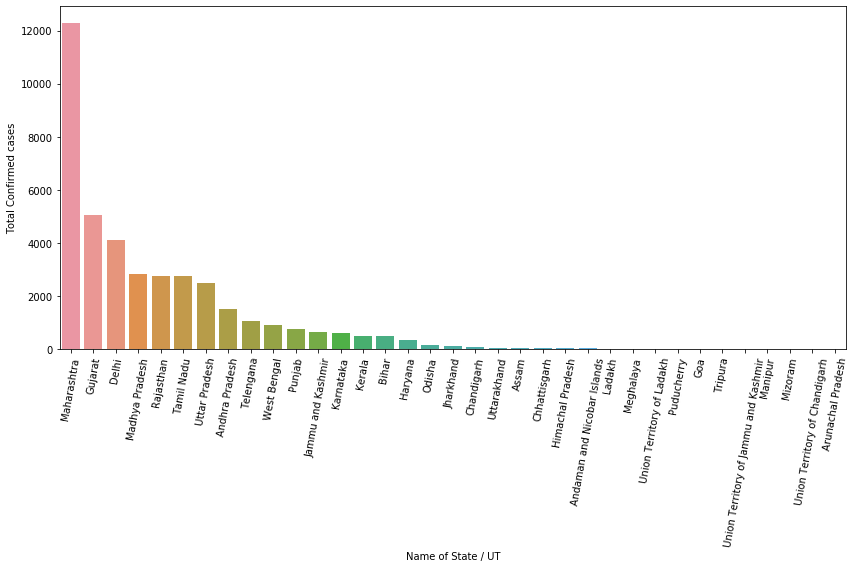

In [20]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'Name of State / UT', y = 	'Total Confirmed cases',data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.tight_layout()

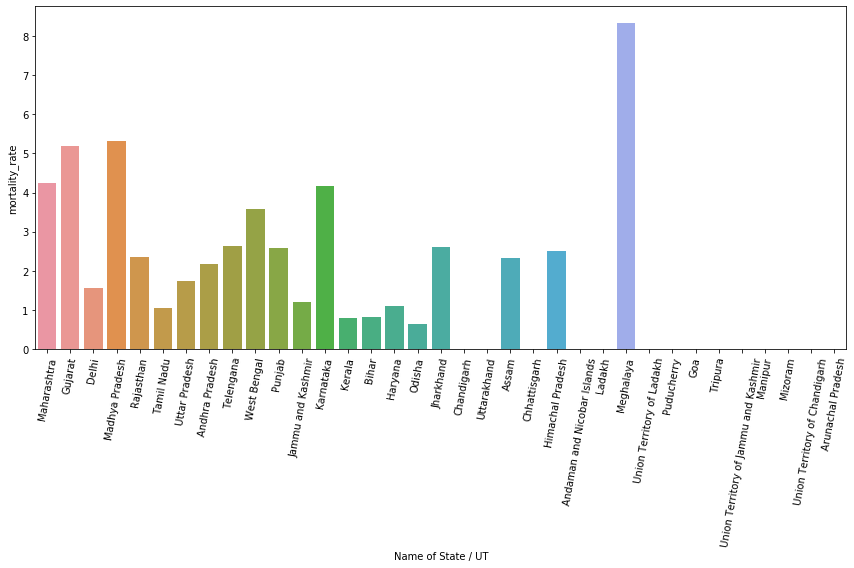

In [21]:
plt.figure(figsize = (12,8))
ax = sns.barplot(x = 'Name of State / UT', y = 	'mortality_rate',data = df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.tight_layout()

In [22]:
df.corr().style.background_gradient(cmap = 'Greens')

,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Latitude,Longitude,Death,Total Confirmed cases,mortality_rate
Total Confirmed cases (Indian National),1.000000,0.410054,0.679477,-0.339068,-0.417180,0.651529,0.689514,0.292669
Total Confirmed cases ( Foreign National ),0.410054,1.000000,0.292292,-0.235766,-0.280871,0.073757,0.137038,0.015773
Cured/Discharged/Migrated,0.679477,0.292292,1.000000,-0.233992,-0.414213,0.771910,0.906739,0.359972
Latitude,-0.339068,-0.235766,-0.233992,1.000000,-0.081900,-0.135117,-0.151970,-0.095972
Longitude,-0.417180,-0.280871,-0.414213,-0.081900,1.000000,-0.310721,-0.346821,-0.096372
Death,0.651529,0.073757,0.771910,-0.135117,-0.310721,1.000000,0.957385,0.463181
Total Confirmed cases,0.689514,0.137038,0.906739,-0.151970,-0.346821,0.957385,1.000000,0.416664
mortality_rate,0.292669,0.015773,0.359972,-0.095972,-0.096372,0.463181,0.416664,1.000000


In [23]:
ind_patient.head(2)

,patient_number,p_id,state_patient_number,date_announced,age_bracket,gender,detected_city,detected_district,detected_state,state_code,...,type_of_transmission,contracted_from_which_patient_suspected,status_change_date,current_status,estimated_onset_date,source1,source2,source3,notes,backup_notes
0,1,P1,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,...,Imported,NaN,14/02/2020,Recovered,NaN,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,Travelled from Wuhan,Student from Wuhan
1,2,P2,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,...,Imported,NaN,14/02/2020,Recovered,NaN,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,Travelled from Wuhan,Student from Wuhan


[Text(0, 0, 'Local'),
 Text(0, 0, 'TBD'),
 Text(0, 0, 'Imported'),
 Text(0, 0, 'Imported '),
 Text(0, 0, 'Unknown')]

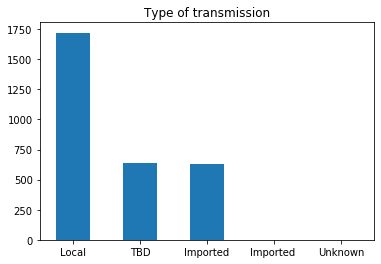

In [24]:
ax = ind_patient['type_of_transmission'].value_counts().plot(kind= 'bar', title = 'Type of transmission')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

In [25]:
pd.DataFrame(ind_patient['detected_district'].value_counts()).style.background_gradient(cmap = 'Greens' , axis =0)

,detected_district
Mumbai,2687
Ahmedabad,2181
Indore,1036
Jaipur,808
Pune,680
Hyderabad,557
Chennai,528
Surat,526
Thane,392
Agra,374


In [26]:
df = ind_patient['age_bracket'].value_counts().sort_values()
df = df.reset_index()
df = df.rename(columns = {'index':'age','age_bracket':'number of patients'})

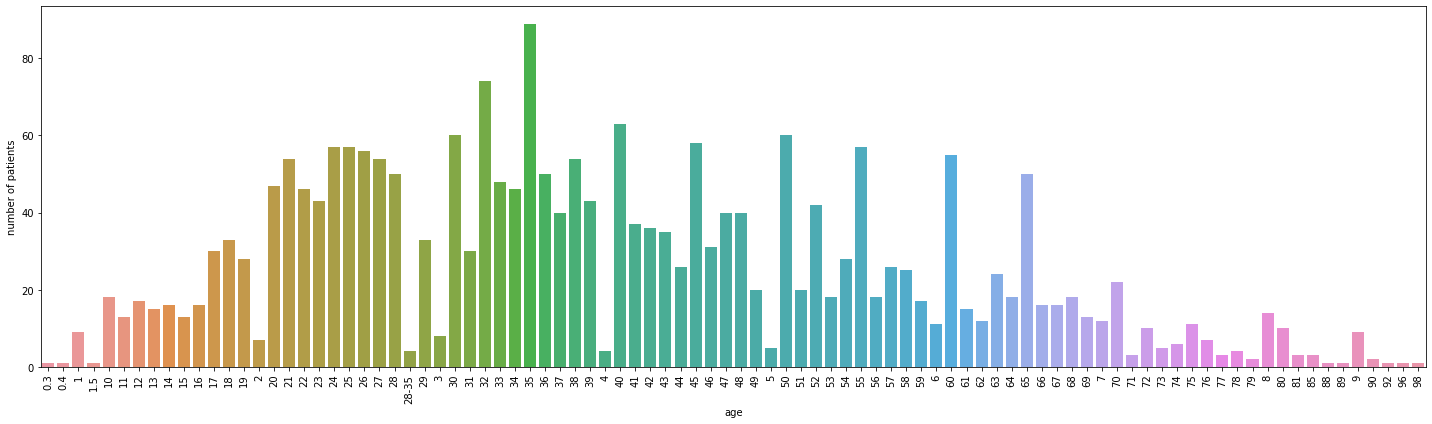

In [27]:
plt.figure(figsize = (20,6))
ax = sns.barplot(x = 'age', y = 'number of patients',data = df.sort_values(by = 'age'))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.tight_layout()

In [28]:
df.sort_values('number of patients' , ascending = False).head(10).style.background_gradient(cmap = 'Greens')

,age,number of patients
91,35,89
90,32,74
89,40,63
88,50,60
87,30,60
86,45,58
85,24,57
84,25,57
83,55,57
82,26,56


# Predicting Covid Cases for next 10 days

In [29]:
india_covid = india_covid.loc[1:]
india_covid.reset_index(inplace = True)

In [30]:
y = india_covid['Confirmed'].values.reshape(-1,1)
days = 10
X_train = np.arange(0,y.shape[0]).reshape(-1,1)
X_test = np.arange(y.shape[0],(y.shape[0]+days)).reshape(-1,1)
X = np.arange(0,(y.shape[0]+days)).reshape(-1,1)

In [31]:
polynomial_features= PolynomialFeatures(degree=4)
x_train_poly = polynomial_features.fit_transform(X_train)
x_test_poly = polynomial_features.fit_transform(X_test)

In [32]:
lm = LinearRegression()

In [33]:
lm.fit(x_train_poly , y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [34]:
train_prediction = lm.predict(x_train_poly)
test_prediction = lm.predict(x_test_poly)

In [35]:
train_prediction = pd.DataFrame(train_prediction)
test_prediction = pd.DataFrame(test_prediction)
actual = india_covid['Confirmed']

In [36]:
test_prediction['index'] = pd.DataFrame(np.arange(y.shape[0],y.shape[0]+days))
test_prediction.set_index('index', inplace = True)
prediction = pd.concat([train_prediction , test_prediction] , axis = 0)
prediction = pd.concat([actual,prediction ], axis = 1)
prediction.rename(columns={'Confirmed':'actual', 0:'Predicted'}, inplace = True)
prediction['Date'] = india_covid['Date']
date_range = pd.date_range(start = pd.to_datetime('2020-01-23') , end = (prediction['Date'].max()+timedelta(days = 10)))
prediction['Date'] = date_range

Text(0, 0.5, 'Confirmed')

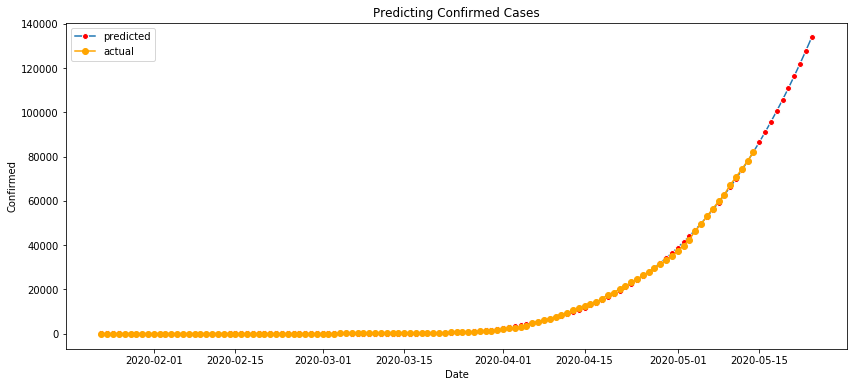

In [37]:
plt.figure(figsize = (14,6))
plt.plot('Date' ,'Predicted', data = prediction, marker = 'o', markerfacecolor = 'red', markeredgecolor = 'white', label = 'predicted')
plt.plot('Date' , 'actual' , data = prediction,marker = 'o', color = 'orange', label = 'actual')
plt.legend()
plt.title('Predicting Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Confirmed')

In [38]:
y = india_covid['Deaths'].values.reshape(-1,1)
lm = LinearRegression()
lm.fit(x_train_poly , y)
train_prediction = lm.predict(x_train_poly)
test_prediction = lm.predict(x_test_poly)
train_prediction = pd.DataFrame(train_prediction)
test_prediction = pd.DataFrame(test_prediction)
actual = india_covid['Deaths']
test_prediction['index'] = pd.DataFrame(np.arange(y.shape[0],y.shape[0]+days))
test_prediction.set_index('index', inplace = True)
prediction = pd.concat([train_prediction , test_prediction] , axis = 0)
prediction = pd.concat([actual,prediction ], axis = 1)
prediction.rename(columns={'Deaths':'actual', 0:'Predicted'}, inplace = True)
prediction['Date'] = india_covid['Date']
date_range = pd.date_range(start = pd.to_datetime('2020-01-23') , end = (prediction['Date'].max()+timedelta(days = 10)))
prediction['Date'] = date_range

Text(0, 0.5, 'Deaths')

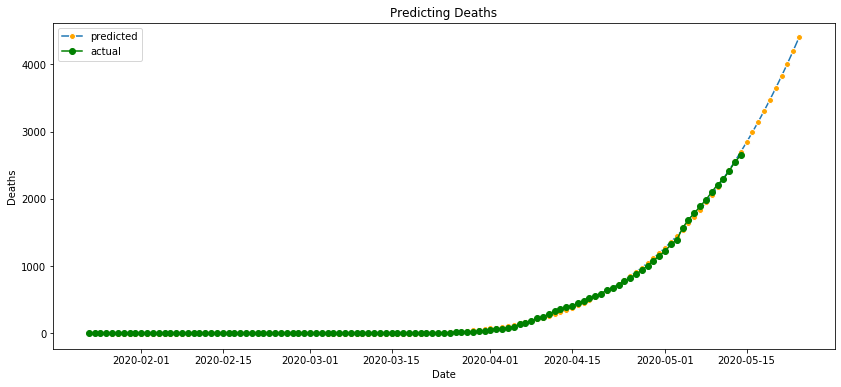

In [39]:
plt.figure(figsize = (14,6))
plt.plot('Date' ,'Predicted', data = prediction, marker = 'o', markerfacecolor = 'orange', markeredgecolor = 'white', label = 'predicted')
plt.plot('Date' , 'actual' , data = prediction,marker = 'o', color = 'green', label = 'actual')
plt.title('Predicting Deaths')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Deaths')

In [40]:
df = ind_comp.groupby('Name of State / UT').max().sort_values(by = 'Total Confirmed cases',ascending = False)
df.reset_index(inplace = True)
df['mortality_rate'] = df['Death']*100/df['Total Confirmed cases']
df[['Name of State / UT','Total Confirmed cases','Total Confirmed cases (Indian National)','Total Confirmed cases ( Foreign National )','Cured/Discharged/Migrated','Death', 'mortality_rate']].style.background_gradient(cmap = 'YlGnBu')

,Name of State / UT,Total Confirmed cases,Total Confirmed cases (Indian National),Total Confirmed cases ( Foreign National ),Cured/Discharged/Migrated,Death,mortality_rate
0,Maharashtra,12296,183,3,2000,521,4.237150
1,Gujarat,5054,52,1,896,262,5.184013
2,Delhi,4122,38,1,1256,64,1.552644
3,Madhya Pradesh,2846,30,0,624,151,5.305692
4,Rajasthan,2770,52,2,1121,65,2.346570
5,Tamil Nadu,2757,36,6,1341,29,1.051868
6,Uttar Pradesh,2487,54,1,689,43,1.728991
7,Andhra Pradesh,1525,14,0,441,33,2.163934
8,Telengana,1063,56,11,458,28,2.634055
9,West Bengal,922,18,0,151,33,3.579176


In [41]:
df = df[['Name of State / UT','Total Confirmed cases']]

In [44]:
df.replace(to_replace=df.loc[2]['Name of State / UT'], value='NCT of Delhi', inplace=True)
df.replace(to_replace=df.loc[30]['Name of State / UT'], value='Jammu & Kashmir', inplace=True)
df.replace(to_replace=df.loc[8]['Name of State / UT'], value='Telangana', inplace=True)
df.replace(to_replace=df.loc[23]['Name of State / UT'], value='Andaman & Nicobar Island', inplace=True)
df.replace(to_replace=df.loc[34]['Name of State / UT'], value='Arunanchal Pradesh', inplace=True)
df.replace(to_replace=df.loc[33]['Name of State / UT'], value='Chandigarh', inplace=True)

In [45]:
fp = "Igismap/Indian_States.shp"
map_df = gpd.read_file(fp)

In [46]:
merged = map_df.set_index('st_nm').join(df.set_index('Name of State / UT'))
merged.loc['Arunanchal Pradesh']['Total Confirmed cases'] = 100

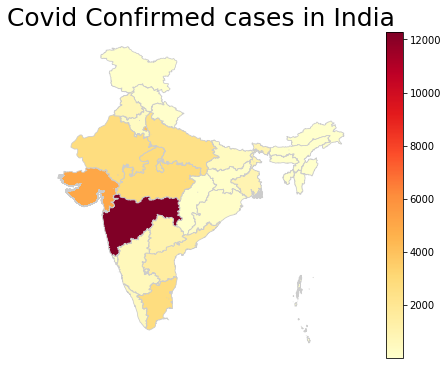

In [51]:
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Covid Confirmed cases in India', fontdict={'fontsize': '25', 'fontweight' : '3'})
merged.plot(column='Total Confirmed cases', linewidth=0.8, ax=ax,legend=True, cmap='YlOrRd', edgecolor='0.8')